# Analysis of different strategies for segmentation

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from skimage import io, filters

from scipy.stats import multivariate_normal
from src.utils.histograms import change_color_space

In [2]:
# Directory containing the images
image_dir = 'data/qsd2_w1'

In [14]:
# List to store the images
images = []
color_space='HSV'

# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = change_color_space(img, color_space)
        images.append(img)

In [ ]:
def get_border_pixel_values(img, border_width=10):
    """
    Get the pixel values of the border of a single channel image
    """

    assert len(img.shape) == 2, "The input image should have a single channel"

    border_pixels = np.concatenate((img[:border_width, :].flatten(),
                                    img[-border_width:, :].flatten(),
                                    img[:, :border_width].flatten(),
                                    img[:, -border_width:].flatten()
                                    ))
    
    return border_pixels

In [ ]:

def create_histogram(data, bins=255):
    """
    Create a histogram from a list of values.

    Parameters:
    - data: List or numpy array of values
    - bins: Number of bins for the histogram

    Returns:
    - hist: The values of the histogram
    - bin_edges: The edges of the bins
    """
    hist, bin_edges = np.histogram(data, bins=bins)
    return hist, bin_edges

def plot_histogram(hist, bin_edges):
    """
    Plot a histogram with lines indicating the mean and standard deviation.

    Parameters:
    - hist: The values of the histogram
    - bin_edges: The edges of the bins
    """
    # Calculate mean and standard deviation
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    mean = np.average(bin_centers, weights=hist)
    std_dev = np.sqrt(np.average((bin_centers - mean) ** 2, weights=hist))
    
    # Plot histogram
    plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', alpha=0.6, color='g', label='Histogram')
    
    # Plot mean and std deviation lines
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(mean + std_dev, color='b', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
    plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')

    # Labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram with Mean and Std Deviation')
    plt.legend()
    plt.show()

    return mean, std_dev

def create_2d_gaussian(data_x, data_y):
    """
    Create a 2D Gaussian distribution based on the means and standard deviations of normalized input data.

    Parameters:
    - data_x: Numpy array of x values
    - data_y: Numpy array of y values

    Returns:
    - z: 2D Gaussian distribution values
    """
    # Normalize data
    #normalized_x = (data_x - np.mean(data_x)) / np.std(data_x)
    #normalized_y = (data_y - np.mean(data_y)) / np.std(data_y)

    mean_x = np.mean(data_x)
    mean_y = np.mean(data_y)
    std_x = np.std(data_x)
    std_y = np.std(data_y)

    # Create a meshgrid for normalized x and y values
    x = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, 100)
    y = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate the 2D Gaussian distribution
    z = (1 / (2 * np.pi * std_x * std_y)) * np.exp(-0.5 * (((X - mean_x) ** 2 / std_x ** 2) + ((Y - mean_y) ** 2 / std_y ** 2)))
    return z

def plot_2d_gaussian(z):
    """
    Plot a 2D Gaussian distribution.

    Parameters:
    - z: 2D Gaussian distribution values
    """
    plt.imshow(z, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis', norm=Normalize(vmin=0, vmax=z.max()))
    plt.colorbar(label='Probability Density')
    plt.title('2D Gaussian Distribution')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


In [ ]:
# Select image index
img_idx = 6

#### Histograms using HSV

In [ ]:
# Choose an image from the list
hsv_image = images[img_idx]

In [ ]:
# Get image channels
h, s, v = cv2.split(hsv_image)

In [ ]:
h_border_values = get_border_pixel_values(h, border_width=10)
s_border_values = get_border_pixel_values(s, border_width=10)
v_border_values = get_border_pixel_values(v, border_width=10)

In [ ]:
h_hist, h_bin_edges = create_histogram(h_border_values, bins=180)
s_hist, s_bin_edges = create_histogram(s_border_values, bins=256)
v_hist, v_bin_edges = create_histogram(v_border_values, bins=256)

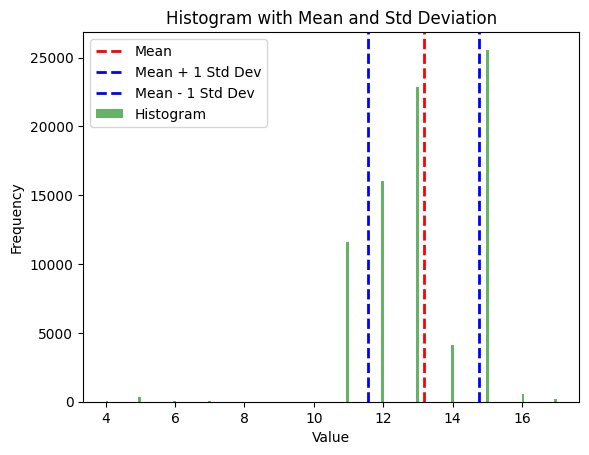

In [ ]:
h_mean, h_std_dev = plot_histogram(h_hist, h_bin_edges)

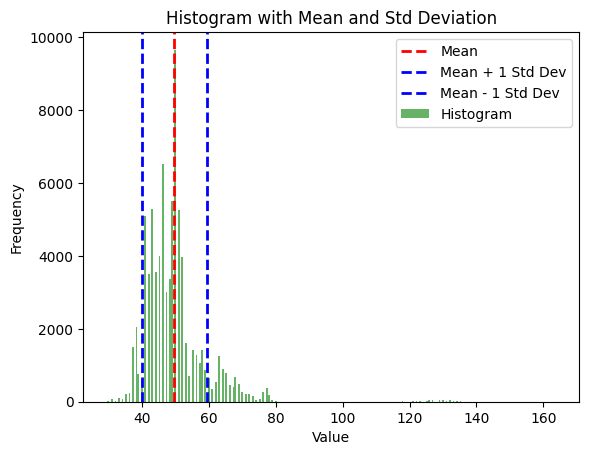

In [ ]:
s_mean, s_std_dev = plot_histogram(s_hist, s_bin_edges)

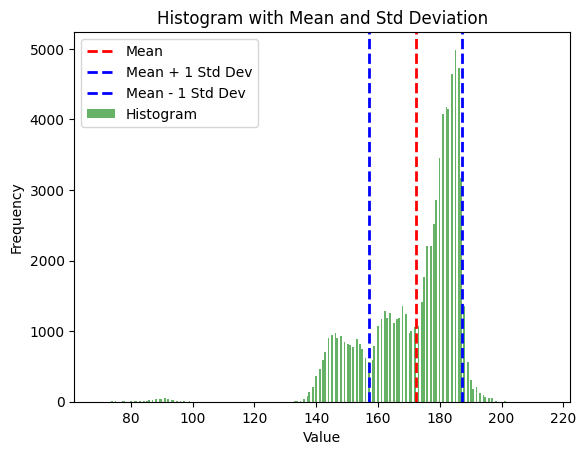

In [ ]:
v_mean, v_std_dev = plot_histogram(v_hist, v_bin_edges)

In [ ]:
hs_gaussian = create_2d_gaussian(h_border_values, s_border_values)
hv_gaussian = create_2d_gaussian(h_border_values, v_border_values)
sv_gaussian = create_2d_gaussian(s_border_values, v_border_values)

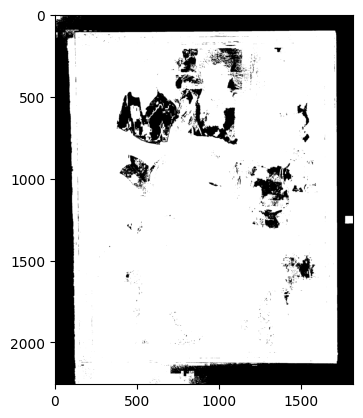

In [ ]:
hs_reconstr = []
for row in hsv_image[:,:,1]:
    hs_reconstr.append(
        np.array([0 if x in range(
            np.floor(h_mean-h_std_dev).astype(int),
            np.ceil(s_mean+s_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(hs_reconstr, cmap='gray')

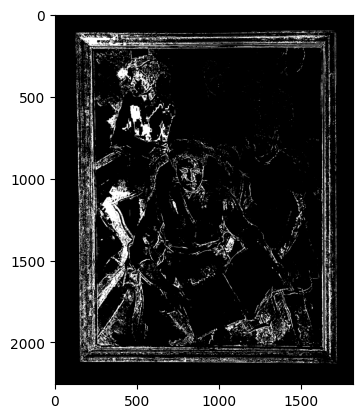

In [ ]:
hv_reconstr = []
for row in hsv_image[:,:,1]:
    hv_reconstr.append(
        np.array([0 if x in range(
            np.floor(h_mean-h_std_dev).astype(int),
            np.ceil(v_mean+v_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(hv_reconstr, cmap='gray')

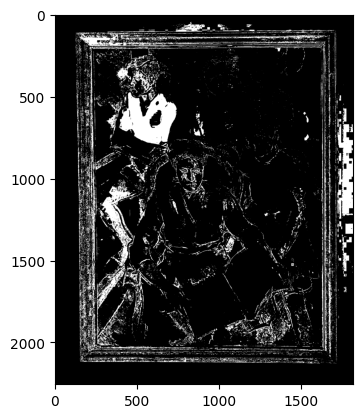

In [ ]:
sv_reconstr = []
for row in hsv_image[:,:,1]:
    sv_reconstr.append(
        np.array([0 if x in range(
            np.floor(s_mean-s_std_dev).astype(int),
            np.ceil(v_mean+v_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(sv_reconstr, cmap='gray')

#### Histograms using CIELab

In [ ]:
lab_images = []
for img in images:
    lab_images.append(change_color_space(img, 'LAB'))

In [ ]:
# Choose an image from the list
lab_image = lab_images[img_idx]

In [ ]:
# Get image channels
l, a, b = cv2.split(lab_image)

In [ ]:
l_border_values = get_border_pixel_values(l, border_width=10)
a_border_values = get_border_pixel_values(a, border_width=10)
b_border_values = get_border_pixel_values(b, border_width=10)

In [ ]:
l_hist, l_bin_edges = create_histogram(l_border_values, bins=256)
a_hist, a_bin_edges = create_histogram(a_border_values, bins=256)
b_hist, b_bin_edges = create_histogram(b_border_values, bins=256)

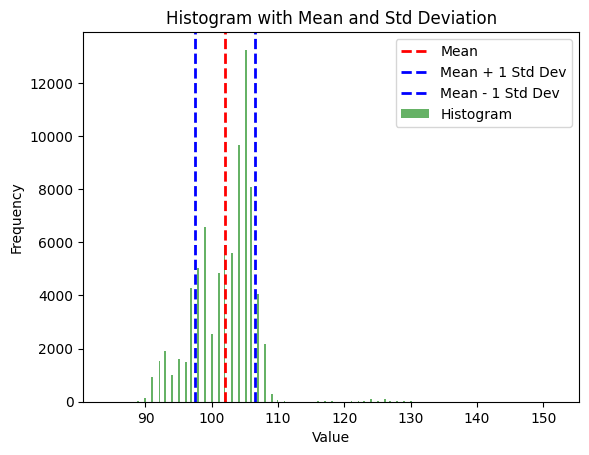

In [ ]:
l_mean, l_std_dev = plot_histogram(l_hist, l_bin_edges)

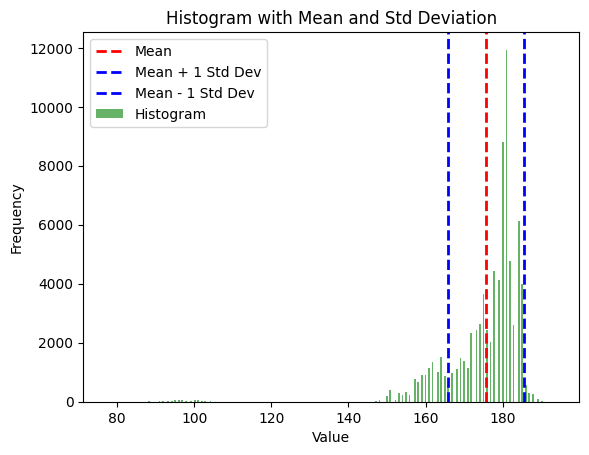

In [ ]:
a_mean, a_std_dev = plot_histogram(a_hist, a_bin_edges)

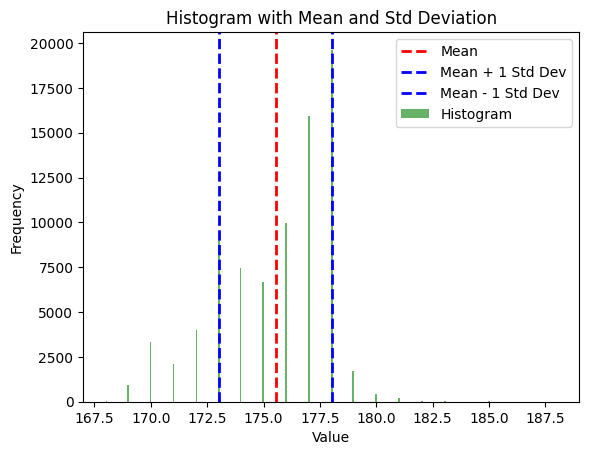

In [ ]:
b_mean, b_std_dev = plot_histogram(b_hist, b_bin_edges)

In [ ]:
la_gaussian = create_2d_gaussian(l_border_values, a_border_values)
lb_gaussian = create_2d_gaussian(l_border_values, b_border_values)
ab_gaussian = create_2d_gaussian(a_border_values, b_border_values)

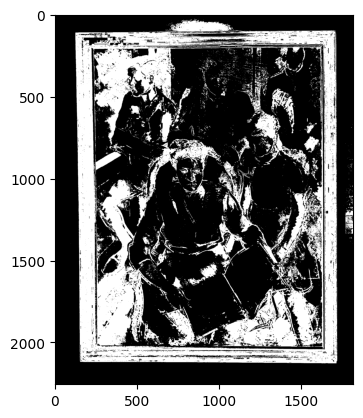

In [ ]:
la_reconstr = []
for row in lab_image[:,:,1]:
    la_reconstr.append(
        np.array([0 if x in range(
            np.floor(l_mean-l_std_dev).astype(int),
            np.ceil(a_mean+a_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(la_reconstr, cmap='gray')

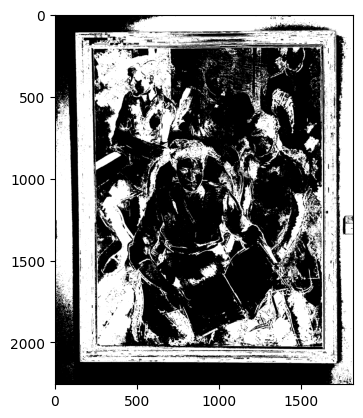

In [ ]:
lb_reconstr = []
for row in lab_image[:,:,1]:
    lb_reconstr.append(
        np.array([0 if x in range(
            np.floor(l_mean-l_std_dev).astype(int),
            np.ceil(b_mean+b_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(lb_reconstr, cmap='gray')

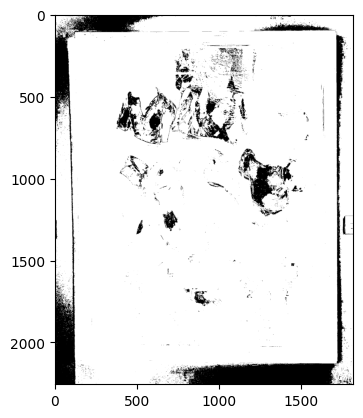

In [ ]:
ab_reconstr = []
for row in lab_image[:,:,1]:
    ab_reconstr.append(
        np.array([0 if x in range(
            np.floor(a_mean-a_std_dev).astype(int),
            np.ceil(b_mean+b_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(ab_reconstr, cmap='gray')

#### Histograms using Grayscale

In [ ]:
gray_images = []
for img in images:
    gray_images.append(change_color_space(img, 'GRAY'))

In [ ]:
# Choose an image from the list
gray_image = gray_images[img_idx]

In [ ]:
g_border_values = get_border_pixel_values(gray_image, border_width=10)

In [ ]:
g_hist, g_bin_edges = create_histogram(g_border_values, bins=256)

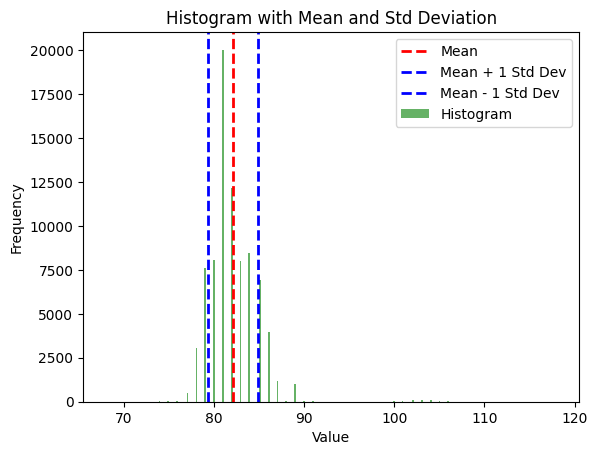

(82.11384975401545, 2.775443103270693)

In [ ]:
plot_histogram(g_hist, g_bin_edges)

#### Histograms using RGB

In [ ]:
rgb_images = []
for img in images:
    rgb_images.append(change_color_space(img, 'RGB'))

In [ ]:
# Choose an image from the list
rgb_image = rgb_images[img_idx]

In [ ]:
# Get image channels
r, g, b = cv2.split(rgb_image)

In [ ]:
r_border_values = get_border_pixel_values(r, border_width=10)
g_border_values = get_border_pixel_values(g, border_width=10)
b_border_values = get_border_pixel_values(b, border_width=10)

In [ ]:
r_hist, r_bin_edges = create_histogram(r_border_values, bins=256)
g_hist, g_bin_edges = create_histogram(g_border_values, bins=256)
b_hist, b_bin_edges = create_histogram(b_border_values, bins=256)

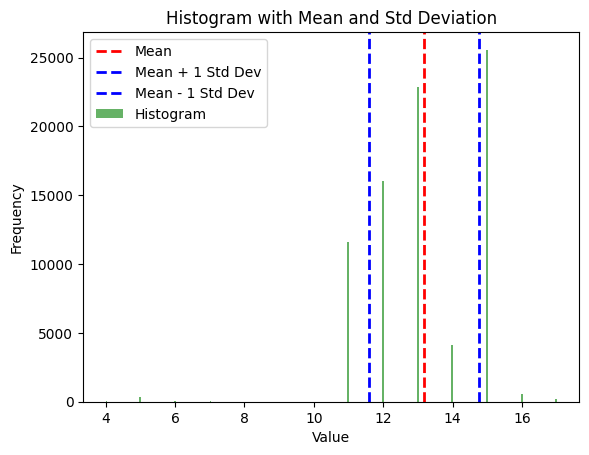

In [ ]:
r_mean, r_std_dev = plot_histogram(r_hist, r_bin_edges)

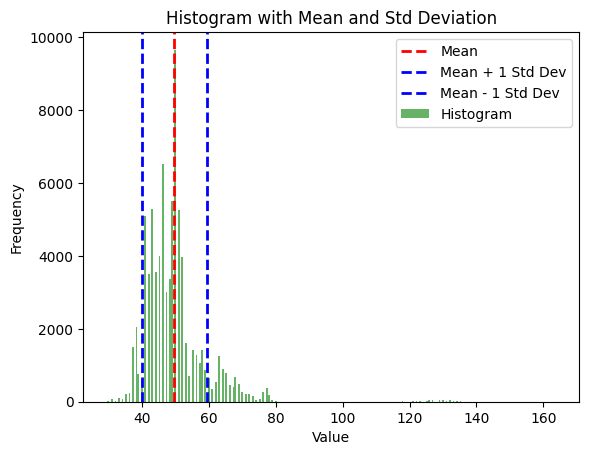

In [ ]:
g_mean, g_std_dev = plot_histogram(g_hist, g_bin_edges)

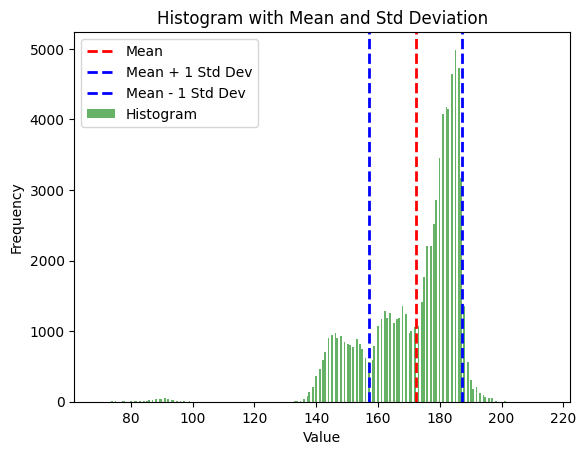

In [ ]:
b_mean, b_std_dev = plot_histogram(b_hist, b_bin_edges)

In [ ]:
rg_gaussian = create_2d_gaussian(r_border_values, g_border_values)
rb_gaussian = create_2d_gaussian(r_border_values, b_border_values)
gb_gaussian = create_2d_gaussian(g_border_values, b_border_values)

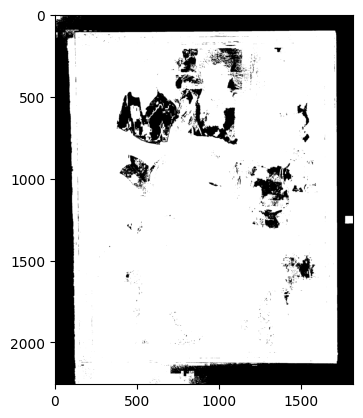

In [ ]:
rg_reconstr = []
for row in rgb_image[:,:,1]:
    rg_reconstr.append(
        np.array([0 if x in range(
            np.floor(r_mean-r_std_dev).astype(int),
            np.ceil(g_mean+g_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(rg_reconstr, cmap='gray')

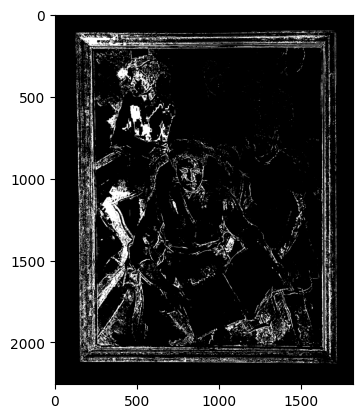

In [ ]:
rb_reconstr = []
for row in rgb_image[:,:,1]:
    rb_reconstr.append(
        np.array([0 if x in range(
            np.floor(r_mean-r_std_dev).astype(int),
            np.ceil(b_mean+b_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(rb_reconstr, cmap='gray')

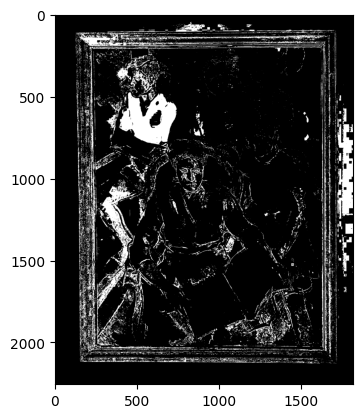

In [ ]:
gb_reconstr = []
for row in rgb_image[:,:,1]:
    gb_reconstr.append(
        np.array([0 if x in range(
            np.floor(g_mean-g_std_dev).astype(int),
            np.ceil(b_mean+b_std_dev).astype(int))
            else 256 for x in row]))
    
plt.imshow(gb_reconstr, cmap='gray')

## Opening Residue

In [ ]:
def opening_residue(img, kernel_size=(50, 50), thres=8):
    
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Invert the image
    grey_img_neg = cv2.bitwise_not(grey_img)

    # Background: opening; (f o B)
    kernel = np.ones(kernel_size, np.uint8)
    opened = cv2.morphologyEx(grey_img_neg, cv2.MORPH_OPEN, kernel)

    # Residue; f - (f o B)
    residue = cv2.subtract(grey_img_neg, opened)

    # Thresholding
    _, thresholded = cv2.threshold(residue, thres, 255, cv2.THRESH_BINARY)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 4, 2)
    plt.title('Negative greyscale')
    plt.imshow(grey_img_neg, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Residue')
    plt.imshow(residue, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title('Thresholded residue')
    plt.imshow(thresholded, cmap='gray')

    plt.tight_layout()
    plt.show()

    return thresholded

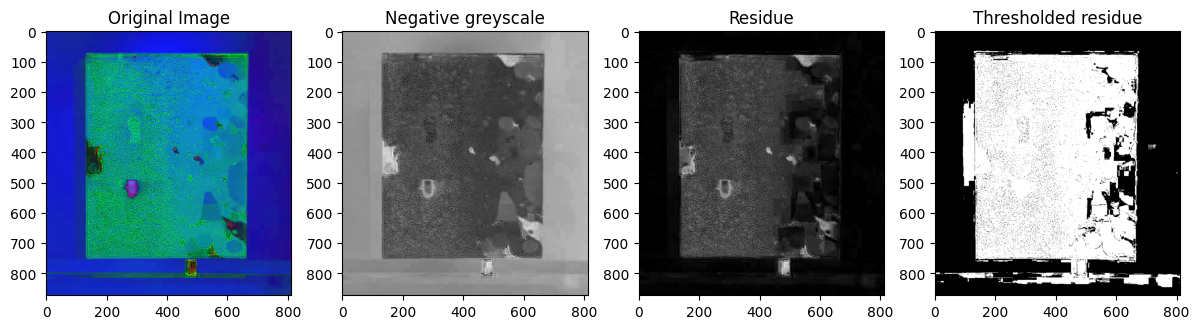

In [ ]:
image_opening_residue = opening_residue(rgb_images[3])

In [ ]:
from scipy.spatial import ConvexHull

kernel_size = (50, 50)
thres = 8

mask_list = []

for img in rgb_images:

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Invert the image
    grey_img_neg = cv2.bitwise_not(grey_img)

    # Background: opening; (f o B)
    kernel = np.ones(kernel_size, np.uint8)
    opened = cv2.morphologyEx(grey_img_neg, cv2.MORPH_OPEN, kernel)

    # Residue; f - (f o B)
    residue = cv2.subtract(grey_img_neg, opened)

    # Thresholding
    _, thresholded = cv2.threshold(residue, thres, 255, cv2.THRESH_BINARY)

    # Apply opening
    kernel = np.ones((4, 4), np.uint8)
    thresholded = cv2.morphologyEx(thresholded.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Get coordinates of segmented region (foreground pixels)
    # Use np.where() and switch order to (x, y) for correct input to cv2 functions
    foreground_coords = np.column_stack(np.where(thresholded)[::-1])

    # Check if there are enough points to form a hull
    if len(foreground_coords) > 2:
        # Compute the convex hull
        hull = ConvexHull(foreground_coords)

        # Create a blank mask to fill the convex hull
        convex_hull_filled = np.zeros_like(thresholded, dtype=np.uint8)

        # Get the vertices of the convex hull
        hull_points = foreground_coords[hull.vertices]

        # Fill the convex hull on the mask
        cv2.fillConvexPoly(convex_hull_filled, hull_points, 255)
    else:
        convex_hull_filled = np.zeros_like(thresholded, dtype=np.uint8)

    mask_list.append(convex_hull_filled)

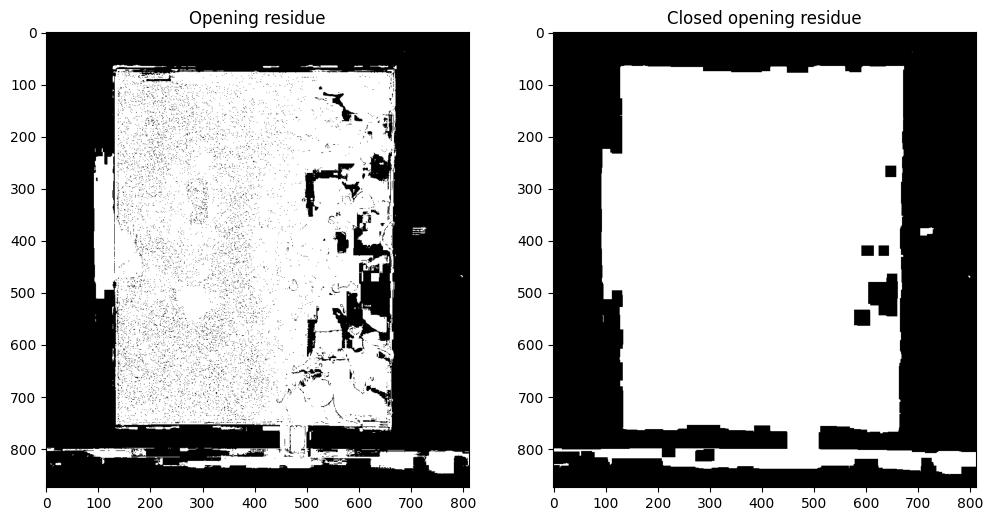

In [ ]:
# Closed opening residue
kernel = np.ones((20, 20), np.uint8)
closed = cv2.morphologyEx(image_opening_residue, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Opening residue')
plt.imshow(image_opening_residue, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Closed opening residue')
plt.imshow(closed, cmap='gray')

## Adaptive Threshold

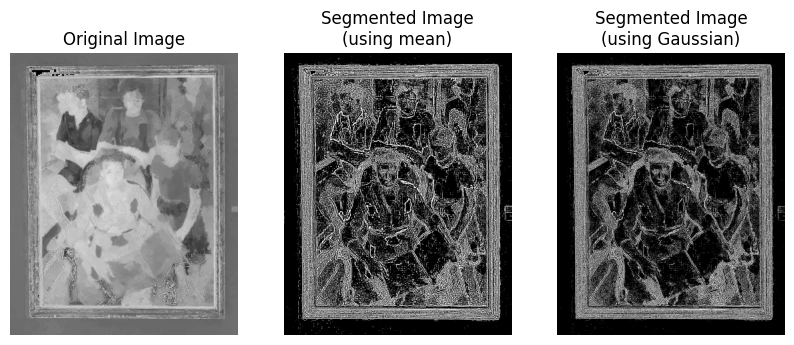

In [ ]:
image = rgb_images[img_idx]

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Adaptive threshold using mean
mean_threshold = cv2.adaptiveThreshold(
    gray,
    255,  # Maximum value
    cv2.ADAPTIVE_THRESH_MEAN_C,  # Adaptive thresholding method
    cv2.THRESH_BINARY,  # Threshold type
    11,  # Neighborhood size (must be odd)
    2  # Constant subtracted from the mean
)

# Adaptive threshold using Gaussian
gaussian_threshold = cv2.adaptiveThreshold(
    gray,
    255,  # Maximum value
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Adaptive thresholding method
    cv2.THRESH_BINARY,  # Threshold type
    11,  # Neighborhood size (must be odd)
    2  # Constant subtracted from the mean
)

# Negative of the obtained image
neg_mean = cv2.bitwise_not(mean_threshold)
neg_gaussian = cv2.bitwise_not(gaussian_threshold)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(neg_mean, cmap='gray')
plt.title(f'Segmented Image\n(using mean)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neg_gaussian, cmap='gray')
plt.title(f'Segmented Image\n(using Gaussian)')
plt.axis('off')

plt.show()

## Otsu's Threshold

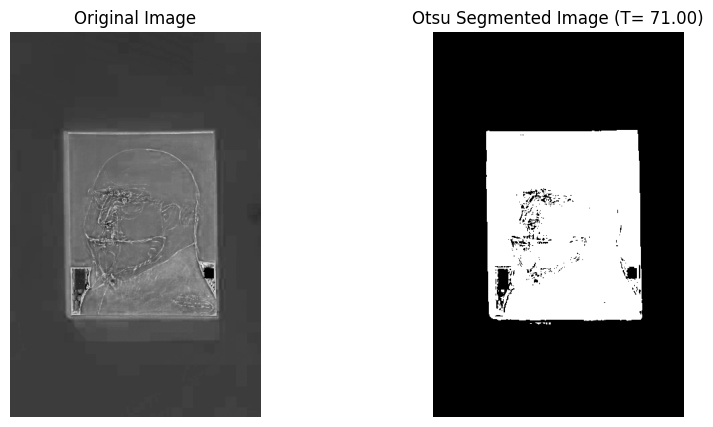

In [ ]:
image = rgb_images[4]

# Grayscale
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Otsu's threshold
otsu_segmented = image > (otsu_threshold := filters.threshold_otsu(image))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(otsu_segmented, cmap='gray')
plt.title(f'Otsu Segmented Image (T={otsu_threshold: .2f})')
plt.axis('off')

plt.show()

In [ ]:
def modified_otsu_thresholding(image, mean_background, variance_background):
    """
    Perform Otsu's thresholding, modified to take into account the known background distribution.
    
    Parameters:
    - image: Input grayscale image
    - mean_background: Mean intensity of the known background pixels
    - variance_background: Variance of the known background pixels
    
    Returns:
    - optimal_threshold: The optimal threshold value for binarization
    """
    # Calculate the histogram of the grayscale image
    pixel_counts, bin_edges = np.histogram(image, bins=np.arange(0, 257), density=False)
    total_pixels = image.size
    probabilities = pixel_counts / total_pixels

    # Initialize variables for threshold search
    max_variance = 0
    optimal_threshold = 0
    sum_all = np.dot(np.arange(256), probabilities)  # Total sum of intensity * probability
    sum_background = 0
    weight_background = 0

    # Iterate over all possible thresholds
    for threshold in range(256):
        weight_background += probabilities[threshold]
        weight_foreground = 1 - weight_background

        if weight_background == 0 or weight_foreground == 0:
            continue

        sum_background += threshold * probabilities[threshold]
        mean_background_current = sum_background / weight_background
        mean_foreground_current = (sum_all - sum_background) / weight_foreground

        # Compute between-class variance
        between_class_variance = weight_background * weight_foreground * \
                                 (mean_background_current - mean_foreground_current) ** 2

        # Apply penalty if background mean deviates from known background distribution
        background_penalty = abs(mean_background_current - mean_background) / variance_background

        # Modify the variance by subtracting the penalty (to favor known background distribution)
        modified_variance = between_class_variance - background_penalty

        # Update the optimal threshold if this threshold gives a larger modified variance
        if modified_variance > max_variance:
            max_variance = modified_variance
            optimal_threshold = threshold

    return optimal_threshold

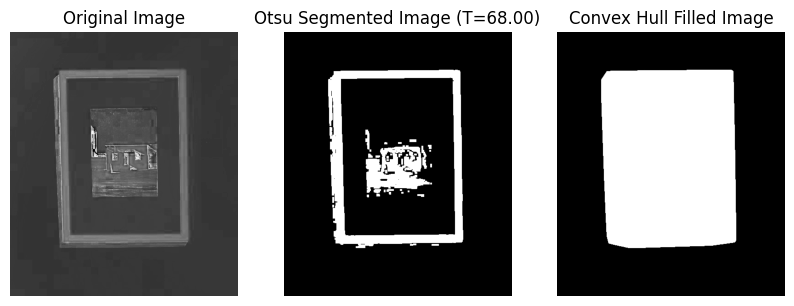

In [ ]:
import cv2
import numpy as np
from skimage import filters
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Original image segmentation code
image = rgb_images[10]
mask_list = []

for image in rgb_images:
    # Grayscale conversion
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Otsu's threshold
    otsu_threshold = filters.threshold_otsu(image)
    otsu_segmented = image > otsu_threshold

    # Apply opening
    kernel = np.ones((4, 4), np.uint8)
    otsu_segmented = cv2.morphologyEx(otsu_segmented.astype(np.uint8), cv2.MORPH_OPEN, kernel)

    # Get coordinates of segmented region (foreground pixels)
    # Use np.where() and switch order to (x, y) for correct input to cv2 functions
    foreground_coords = np.column_stack(np.where(otsu_segmented)[::-1])

    # Check if there are enough points to form a hull
    if len(foreground_coords) > 2:
        # Compute the convex hull
        hull = ConvexHull(foreground_coords)

        # Create a blank mask to fill the convex hull
        convex_hull_filled = np.zeros_like(otsu_segmented, dtype=np.uint8)

        # Get the vertices of the convex hull
        hull_points = foreground_coords[hull.vertices]

        # Fill the convex hull on the mask
        cv2.fillConvexPoly(convex_hull_filled, hull_points, 255)
    else:
        convex_hull_filled = np.zeros_like(otsu_segmented, dtype=np.uint8)

    mask_list.append(convex_hull_filled)
# Plot the results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Otsu segmented image
plt.subplot(1, 3, 2)
plt.imshow(otsu_segmented, cmap='gray')
plt.title(f'Otsu Segmented Image (T={otsu_threshold:.2f})')
plt.axis('off')

# Convex hull filled image
plt.subplot(1, 3, 3)
plt.imshow(convex_hull_filled, cmap='gray')
plt.title('Convex Hull Filled Image')
plt.axis('off')

plt.show()




In [ ]:
output_dir = ".\data\qsd2_w1_masks"
eval_masks =[]
os.makedirs(output_dir, exist_ok=True)
for i, mask in enumerate(mask_list):
    filename = str(i).zfill(5)+".png"
    save_path = os.path.join(output_dir,filename)
    eval_masks.append(save_path)
    cv2.imwrite(save_path, mask)

## Mean Shift

In [4]:
from src.utils.score_painting_retrieval import score_pixel_masks, score_pixel_mask_list

images_mask = []
color_space='GRAY'
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = change_color_space(img, color_space)
            images_mask.append(img)

In [5]:
def mean_shift(img):
    """
    Creates binary masks that removes the background using Mean Shift Filtering and
    enhances it with otsu and binary thresholding

    Parameters
    ----------
    img:
        Image that you want the background to be removed from

    Returns
    -------
    img:
        Contains the binary mask with the removed background
    """


    negative = cv2.bitwise_not(img)
    
    shifted = cv2.pyrMeanShiftFiltering(negative, sp=21, sr=51)

    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_mask_inv = cv2.bitwise_not(binary_mask)

    return binary_mask_inv


In [6]:
new_masks = []
for img in images:
    new_masks.append(mean_shift(img))

(-0.5, 549.5, 564.5, -0.5)

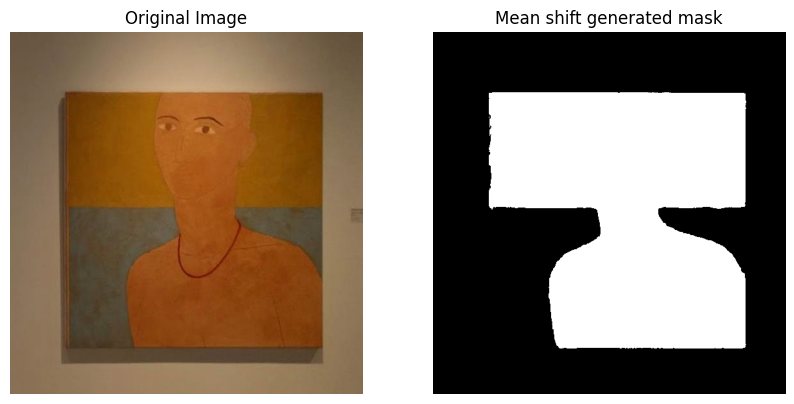

In [19]:
# Plot the results
plt.figure(figsize=(10, 5))

# Original image
img = cv2.cvtColor(images[2], cv2.COLOR_HSV2RGB)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Otsu segmented image
plt.subplot(1, 2, 2)
plt.imshow(new_masks[2], cmap='gray')
plt.title('Mean shift generated mask')
plt.axis('off')

In [ ]:
mean_shift_results = {}
mean_shift_results["base_method"] = score_pixel_mask_list(new_masks, images_mask)

### Mean shift with Closing and Morphological reconstruction

In [ ]:
import itertools
closing_kernels = [10, 25, 50, 100, 200, 500, 1000]
morph_kernels = [1, 5, 10, 20, 50, 100, 200]
for clos, morph  in itertools.product(closing_kernels, morph_kernels):
    processed_masks = []
    for mask in new_masks:
        kernel = np.ones((clos, clos), np.uint8)
        binary_mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        marker = cv2.erode(binary_mask_closed, np.ones((morph, morph), np.uint8))
        reconstruction = cv2.dilate(marker, np.ones((morph, morph), np.uint8))
        processed_masks.append(reconstruction)
    mean_shift_results["closing:"+str(clos)+" - morpho:"+str(morph)] = score_pixel_mask_list(processed_masks, images_mask)

In [ ]:
import pandas as pd
plt.style.use('ggplot')

In [ ]:
df = pd.DataFrame.from_dict(mean_shift_results, orient='index', columns=['Precision', 'Sensitivity', 'F1']).reset_index()

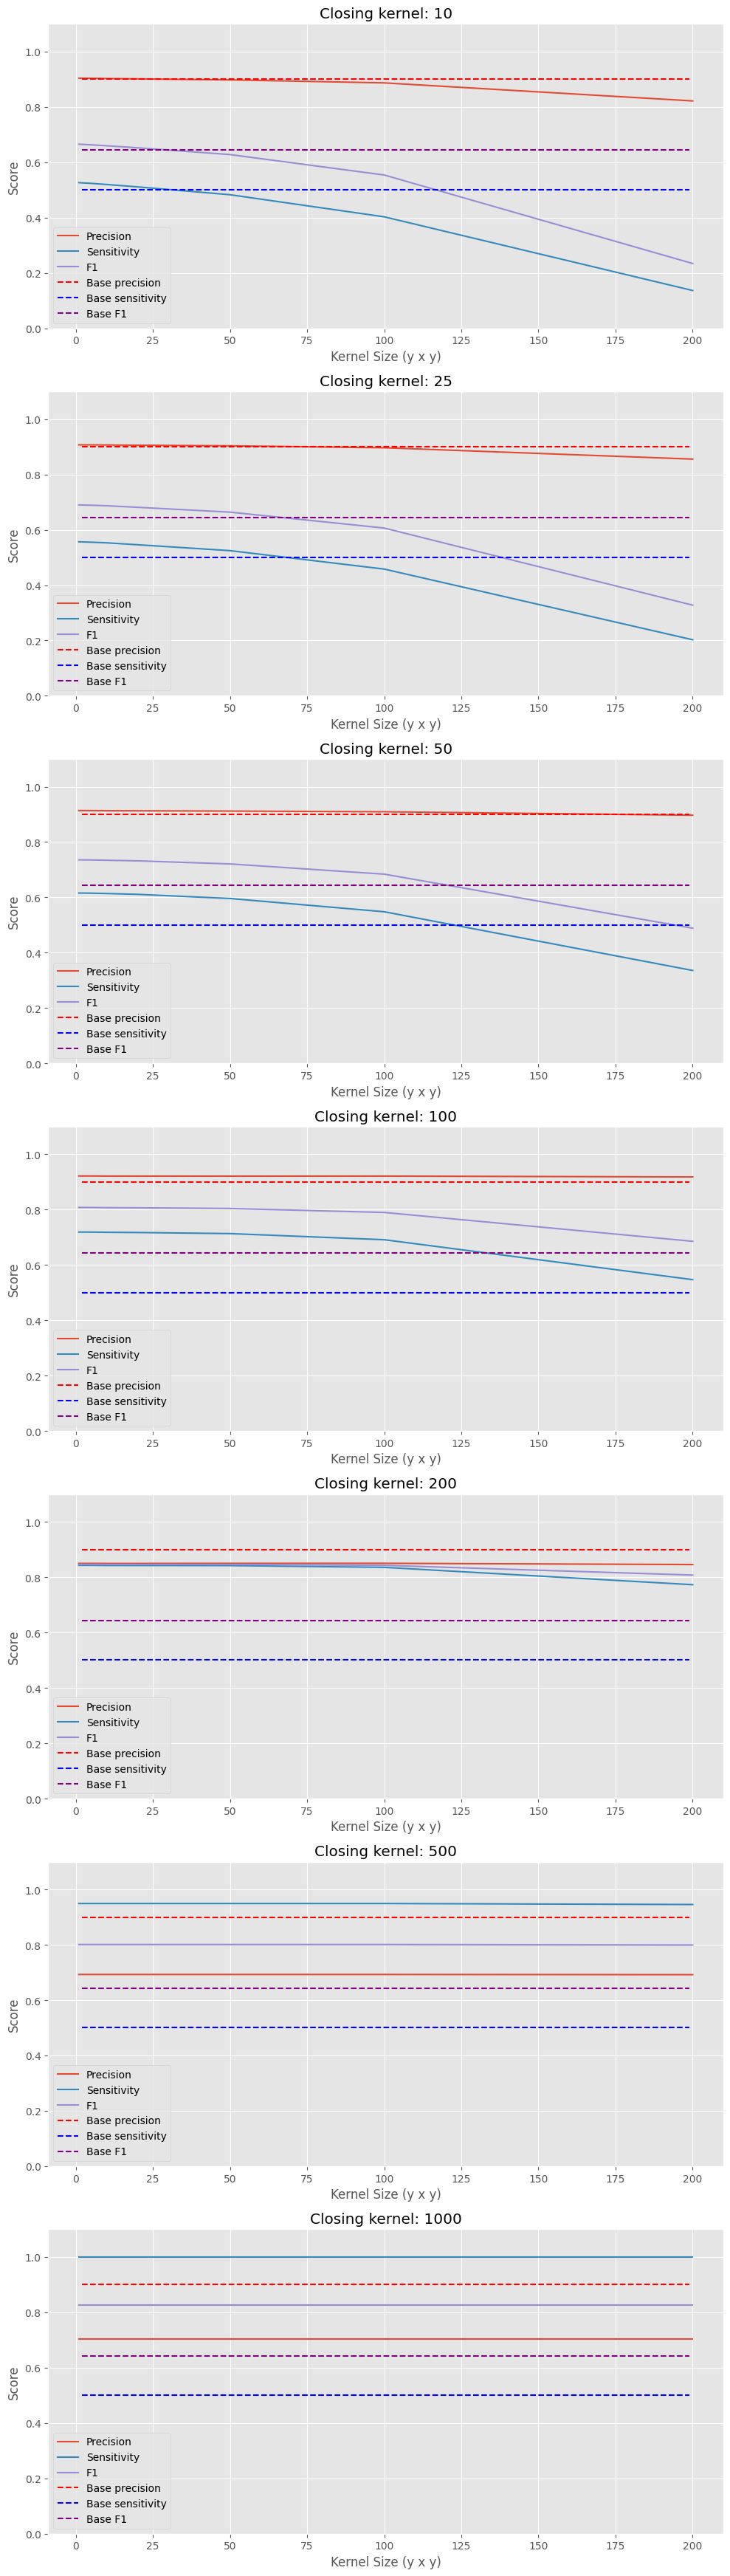

In [ ]:
fig, axs = plt.subplots(figsize = (10,35), nrows = len(closing_kernels), ncols=1)
axs = axs.flatten()
for ax, closing in zip(axs, closing_kernels):
    closing_df = df[df["index"].str.contains(f"closing:{closing} ")]
    ax.plot(morph_kernels, closing_df.Precision, label = "Precision")
    ax.plot(morph_kernels, closing_df.Sensitivity, label = "Sensitivity")
    ax.plot(morph_kernels, closing_df.F1, label = "F1")
    ax.axhline(y=df[(df["index"]=="base_method")]["Precision"][0], linestyle="--", label = "Base precision", color='r', xmin=0.05, xmax=0.95)
    ax.axhline(y=df[(df["index"]=="base_method")]["Sensitivity"][0], linestyle="--", label = "Base sensitivity", color='b', xmin=0.05, xmax=0.95)
    ax.axhline(y=df[(df["index"]=="base_method")]["F1"][0], linestyle="--", label = "Base F1", color='purple', xmin=0.05, xmax=0.95)
    ax.set_title(f"Closing kernel: {closing}")
    ax.set_ylim([0,1.1])
    ax.set_xlabel("Kernel Size (y x y)")
    ax.set_ylabel("Score")
    ax.legend(loc="lower left")

plt.tight_layout()
plt.show()